# Project Water Resource Engineering and Management

## Import librires

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import calendar
import pandas as pd
from datetime import date, timedelta
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Import data

In [134]:
# (Andrea)
# Read txt files and create a pandas dataframe
s1 = np.loadtxt("data/S1flow.txt", delimiter=',')
s2 = np.loadtxt("data/S2flow.txt")

# Create a date range for the data
s1_date_range = pd.date_range(start="2016-12-28", end="2022-12-31", freq='D')
s2_date_range = pd.date_range(start="2003-01-01", end="2022-12-31", freq='D')

# Sanity check
assert len(s1) == len(s1_date_range), "S1 file length doesn't match expected date range"
assert len(s2) == len(s2_date_range), "S2 file length doesn't match expected date range"

# Create 2 differente dataframes with the dates as index and then concatenate them
df_d1 = pd.DataFrame(s1, columns=['flow_S1'], index=s1_date_range)
df_d2 = pd.DataFrame(s2, columns=['flow_S2'], index=s2_date_range)
df_flows = pd.concat([df_d1, df_d2], axis=1)

In [135]:
''' BEN
flow1 = np.loadtxt("data/S1flow.txt", delimiter=',')
flow2 = np.loadtxt("data/S2flow.txt")
s1 = pd.Series(flow1)
s2 = pd.Series(flow2)
# Read txt files and create a pandas dataframe
df_flows = pd.read_csv("data/S1flow.txt", sep=",", header=None)
df_flows.columns = ["S1flow"]
'''

' BEN\nflow1 = np.loadtxt("data/S1flow.txt", delimiter=\',\')\nflow2 = np.loadtxt("data/S2flow.txt")\ns1 = pd.Series(flow1)\ns2 = pd.Series(flow2)\n# Read txt files and create a pandas dataframe\ndf_flows = pd.read_csv("data/S1flow.txt", sep=",", header=None)\ndf_flows.columns = ["S1flow"]\n'

In [136]:
# Check data
print(f"Shape Flow 1 days: {df_d1.shape[0]}")
print(f"Shape Flow 2 days: {df_d2.shape[0]}")
print(f"Flow 1 start date: {df_d1.index[0]}")
print(f"Flow 1 end date: {df_d1.index[-1]}")
print(f"Flow 2 start date: {df_d2.index[0]}")
print(f"Flow 2 end date: {df_d2.index[-1]}")
print(f"Flow 1 missing days: {df_d1.isna().sum()}")
print(f"Flow 2 missing days: {df_d2.isna().sum()}")
print(f"df_flows flow1 missing days: {df_flows['flow_S1'].isna().sum()}")
print(f"df_flows flow2 missing days: {df_flows['flow_S2'].isna().sum()}")
print(f"flow2.shape - flow1.shape: {df_d2.shape[0] - df_d1.shape[0]}")
print(f"zero values flow 1: {(df_flows['flow_S1']==0).sum()}")

Shape Flow 1 days: 2195
Shape Flow 2 days: 7305
Flow 1 start date: 2016-12-28 00:00:00
Flow 1 end date: 2022-12-31 00:00:00
Flow 2 start date: 2003-01-01 00:00:00
Flow 2 end date: 2022-12-31 00:00:00
Flow 1 missing days: flow_S1    0
dtype: int64
Flow 2 missing days: flow_S2    0
dtype: int64
df_flows flow1 missing days: 5110
df_flows flow2 missing days: 0
flow2.shape - flow1.shape: 5110
zero values flow 1: 628


## Part 1

### Point a
Plot the last years of available data for the two stations S1 and S2 one vs the other to see if data are correlated (fit a polynomial function of adequate degree) and use the correlation structure to fill in the missing data. Neglect the noise

Pearson correlation coefficient between S1 and S2 flows: 0.99185


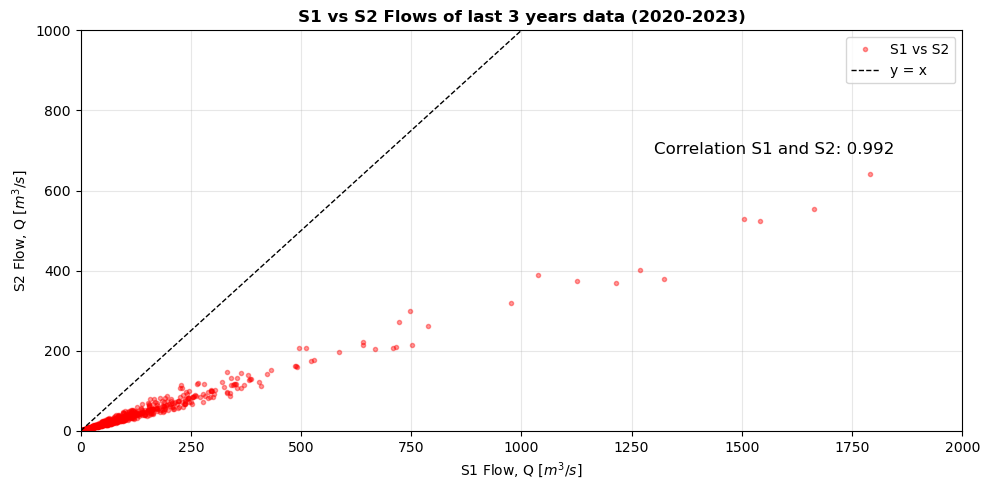

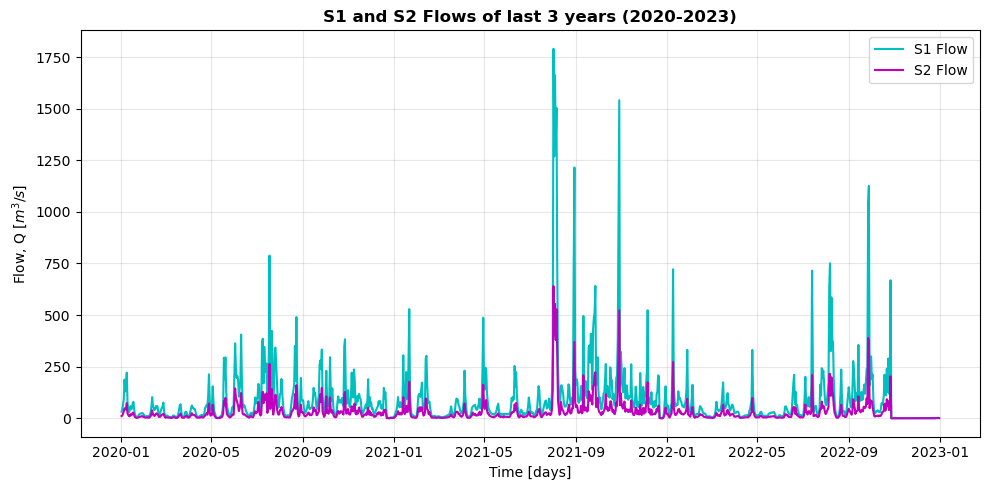

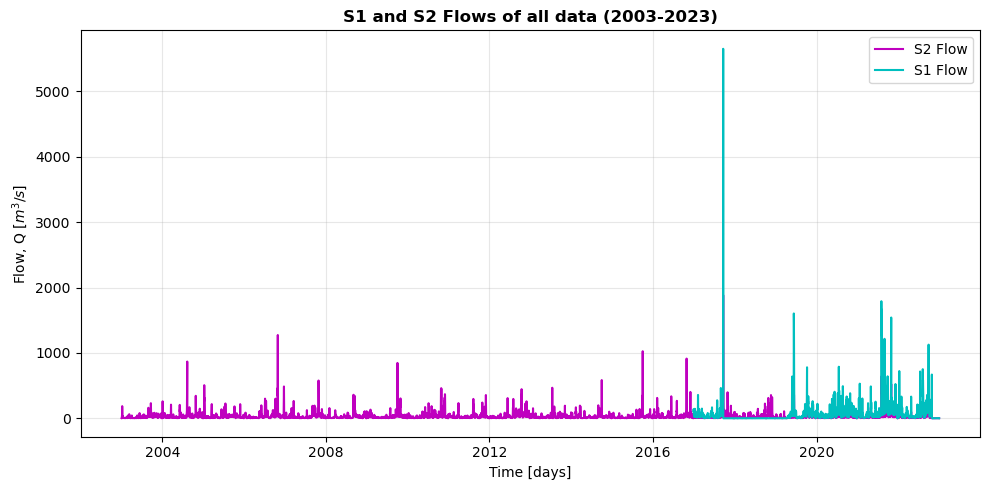

In [137]:
# Take the last 3 years values (from 2020-01-01 to 2022-12-31)
# Compute correlation coefficitient and plot
last_days = 365*3
s1_check = df_flows['flow_S1'].iloc[-last_days:]
s2_check = df_flows['flow_S2'].iloc[-last_days:]

# Compute Pearson correlation coefficient
rho = s1_check.corr(s2_check)
print(f"Pearson correlation coefficient between S1 and S2 flows: {rho:.5f}")

# Plot correlation and flows
plt.figure(figsize=(10, 5))
plt.plot(s1_check, s2_check, 'o', color='r', markersize=3, alpha=0.4, label='S1 vs S2')
plt.plot([0, 2000], [0, 2000], 'k--', lw=1, label='y = x')
plt.xlabel('S1 Flow, Q [$m^3/s$]')
plt.ylabel('S2 Flow, Q [$m^3/s$]')
plt.xlim(0, 2000)
plt.ylim(0, 1000)
plt.title('S1 vs S2 Flows of last 3 years data (2020-2023)', fontweight='bold')
plt.grid(alpha=0.3)
plt.legend()
plt.text(1300, 690, f'Correlation S1 and S2: {rho:.3f}', fontsize=12, color='k')
plt.tight_layout()
plt.savefig("figures/flow_correlation.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(s1_check, label='S1 Flow', color='c')
plt.plot(s2_check, label='S2 Flow', color='m')
plt.xlabel('Time [days]')
plt.ylabel('Flow, Q [$m^3/s$]')
plt.title('S1 and S2 Flows of last 3 years (2020-2023)', fontweight='bold')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("figures/S1_S2_flow_2020-2023.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_flows['flow_S2'], label='S2 Flow', color='m')
plt.plot(df_flows['flow_S1'], label='S1 Flow', color='c')
plt.xlabel('Time [days]')
plt.ylabel('Flow, Q [$m^3/s$]')
plt.title('S1 and S2 Flows of all data (2003-2023)', fontweight='bold')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("figures/S1_S2_flow_2003-2023.png", dpi=300)
plt.show()

It's possible to notice in the last plot that the S1 flow have missing values inside the series. Moreover the series start after the S2 series. so first the mssing values inside S1 flow should be filled, using a polynomial fucntion and the correlation structure. Then the entrie S1 series must be prolonged to the same lenght of the S2 series. then it must be prolonged again in order to have 30 years of data of S1 flow, so 10 more years, using the swpping technique

In [140]:
# BEN
'''# Extract last years
years = 365 * 3
lasty_f1 = flow1[-years:] 
lasty_f2 = flow2[-years:]

x = np.linspace(1,years,years) 

# Calculate Pearson correlation
correlation = np.corrcoef(lasty_f1, lasty_f2)[0, 1]
print(f"Pearson correlation: {correlation:.5f}")

# Plot entire series and last years for both
#plt.figure(figsize=(6, 4), dpi=300)
plt.plot(x,lasty_f1, label = "flow 1")
plt.plot(x,lasty_f2, label = "flow 2")
plt.legend()
plt.grid(alpha=0.3)
plt.title("Last 3 years of flow data")
plt.xlabel("Time [days]")
plt.ylabel("Flow, Q [m^3/day]")
plt.show()'''

'# Extract last years\nyears = 365 * 3\nlasty_f1 = flow1[-years:] \nlasty_f2 = flow2[-years:]\n\nx = np.linspace(1,years,years) \n\n# Calculate Pearson correlation\ncorrelation = np.corrcoef(lasty_f1, lasty_f2)[0, 1]\nprint(f"Pearson correlation: {correlation:.5f}")\n\n# Plot entire series and last years for both\n#plt.figure(figsize=(6, 4), dpi=300)\nplt.plot(x,lasty_f1, label = "flow 1")\nplt.plot(x,lasty_f2, label = "flow 2")\nplt.legend()\nplt.grid(alpha=0.3)\nplt.title("Last 3 years of flow data")\nplt.xlabel("Time [days]")\nplt.ylabel("Flow, Q [m^3/day]")\nplt.show()'

In [141]:
# Boolean mask of zeros
mask = (df_flows['flow_S1'] == 0)

# Find start points: zero (true) today AND non‐zero (false) (start of series) yesterday [**1100**]
# ---------1100000001111----------
start = mask & ~mask.shift(fill_value=False)
# Find end points: zero today, non‐zero (end of series) tomorrow [**0011**]
end = mask & ~mask.shift(-1, fill_value=False)

# Get the indices
starts_idx = df_flows.index[start]
ends_idx = df_flows.index[end]

# Compute duration of each run (in days), plus 1 to include the last day
durations = (ends_idx - starts_idx).days + 1

# Pick the longest run
idx_long = np.argmax(durations)
start_missing = starts_idx[idx_long]
end_missing = ends_idx[idx_long]

print(f"Missing block S1 block:\n   Start\t{start_missing}\n   End\t\t{end_missing}\n   Duration\t{durations[idx_long]} days")

Missing block S1 block:
   Start	2017-09-20 00:00:00
   End		2019-04-10 00:00:00
   Duration	568 days


In [142]:
# Define masks based on your detected block
mask_missing = (df_flows.index >= start_missing) & (df_flows.index <= end_missing)
# Build a training mask: any day not in the missing block AND with a non-NaN S1 flow
mask_obs = (~mask_missing) & df_flows['flow_S1'].notna() 

# Extract observed data, X_obs: S2, y_obs: S1
X_obs = df_flows.loc[mask_obs, 'flow_S2'].values.reshape(-1,1)
y_obs = df_flows.loc[mask_obs, 'flow_S1'].values

# Fit polynomial function of chosen degree
deg = 1
poly = PolynomialFeatures(degree=deg, include_bias=False)
Xp = poly.fit_transform(X_obs)
model = LinearRegression().fit(Xp, y_obs)
score = model.score(Xp, y_obs)
print(f"R^2 on observed days:\t\t\t{score:.5f}")
# Predict only on the true missing block
X_miss = df_flows.loc[mask_missing, 'flow_S2'].values.reshape(-1,1)
Xp_miss = poly.transform(X_miss)
predictions = model.predict(Xp_miss)

# Store into a new column
df_flows['flow_S1_filled'] = df_flows['flow_S1']
df_flows.loc[mask_missing, 'flow_S1_filled'] = predictions
print(f"length flow_S1_filled:\t\t\t{len(df_flows['flow_S1_filled'])}")
print(f"length preditions:\t\t\t{len(predictions)}")
print(f"number of filled S1 missing values:\t{mask_missing.sum()}")

R^2 on observed days:			0.98726
length flow_S1_filled:			7305
length preditions:			568
number of filled S1 missing values:	568


RMSE on S1 flow observed days (where true values are available):  +-23.039 m^3/s on average


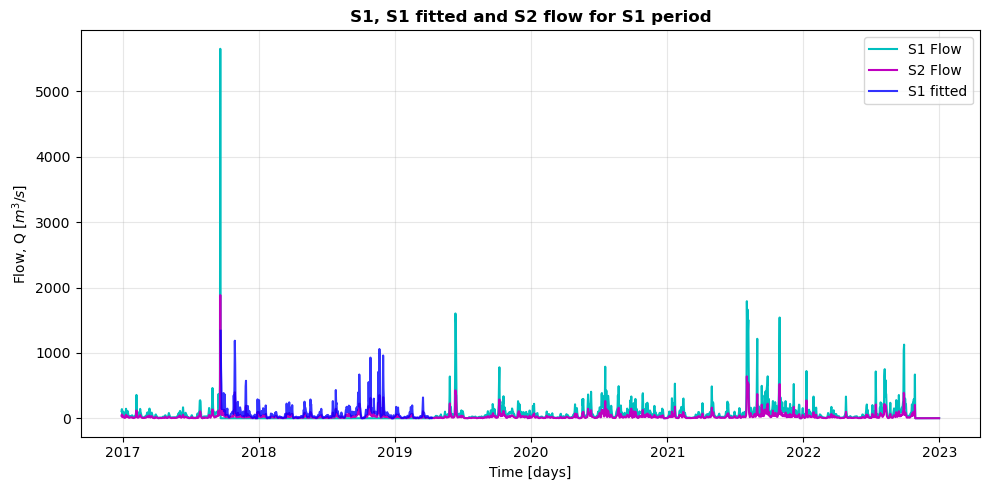

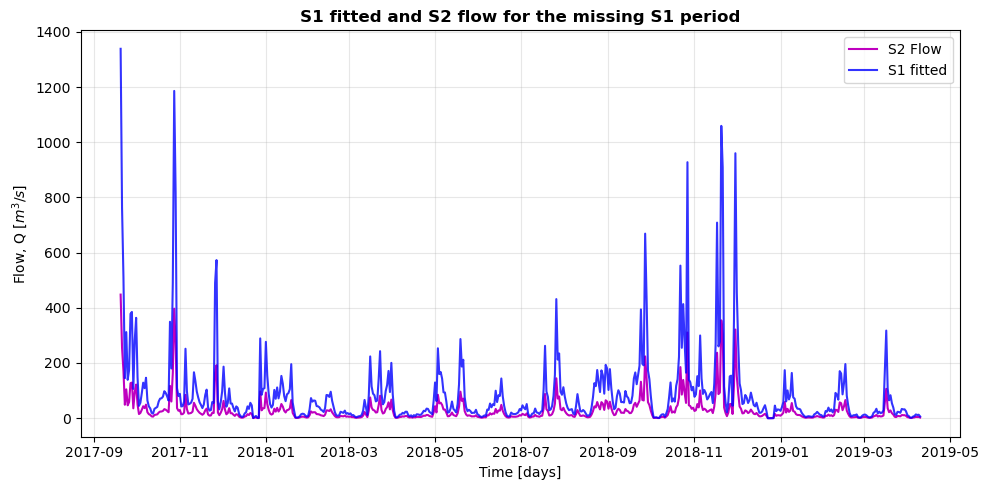

In [144]:
# Compute error metrics on the observed portion
y_pred_obs = model.predict(poly.transform(X_obs))
rmse = np.sqrt(mean_squared_error(y_obs, y_pred_obs))
print(f"RMSE on S1 flow observed days (where true values are available):  +-{rmse:.3f} m^3/s on average")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df_flows['flow_S1'].loc["2016-12-28":"2022-12-31"], label='S1 Flow', color='c')
plt.plot(df_flows['flow_S2'].loc["2016-12-28":"2022-12-31"], label='S2 Flow', color='m')
plt.plot(df_flows['flow_S1_filled'].loc[start_missing:end_missing], label='S1 fitted', color='blue', alpha=0.8)
plt.xlabel('Time [days]')
plt.ylabel('Flow, Q [$m^3/s$]')
plt.title('S1, S1 fitted and S2 flow for S1 period', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/S1_S2_S1filled.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_flows['flow_S2'].loc[start_missing:end_missing], label='S2 Flow', color='m')
plt.plot(df_flows['flow_S1_filled'].loc[start_missing:end_missing], label='S1 fitted', color='blue', alpha=0.8)
plt.xlabel('Time [days]')
plt.ylabel('Flow, Q [$m^3/s$]')
plt.title('S1 fitted and S2 flow for the missing S1 period', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/S2_S1filled.png", dpi=300)
plt.show()

In [145]:
# BEN
'''# Find relation between s1 and s2
# Step 1: id if lag between s1 and s2
ind_max1 = np.argmax(lasty_f1)
ind_max2 = np.argmax(lasty_f2)
print(ind_max1)
print(ind_max2)

#Step 2: fit a polynomial
n = 1 #degree
coef = np.polyfit(lasty_f2, lasty_f1, deg = n)
model = np.poly1d(coef) #test model

#Step 3: id missing values in s1 and replace by model
ind_missing_s1_Start = 266
ind_missing_s1_end = 834

ddata = 834-266

ind_s2 = len(s2)-(len(s1)-834)

s1[ind_missing_s1_Start:ind_missing_s1_end] = model(s2[ind_s2-ddata:ind_s2])

#Step 4 : Plot to visualise
x = np.arange(1,ddata+1)

#plt.figure(figsize=(6, 3), dpi=300) 
plt.plot(x,s1[ind_missing_s1_Start:ind_missing_s1_end])
plt.plot(x,s2[ind_s2-ddata:ind_s2])
plt.show()'''

'# Find relation between s1 and s2\n# Step 1: id if lag between s1 and s2\nind_max1 = np.argmax(lasty_f1)\nind_max2 = np.argmax(lasty_f2)\nprint(ind_max1)\nprint(ind_max2)\n\n#Step 2: fit a polynomial\nn = 1 #degree\ncoef = np.polyfit(lasty_f2, lasty_f1, deg = n)\nmodel = np.poly1d(coef) #test model\n\n#Step 3: id missing values in s1 and replace by model\nind_missing_s1_Start = 266\nind_missing_s1_end = 834\n\nddata = 834-266\n\nind_s2 = len(s2)-(len(s1)-834)\n\ns1[ind_missing_s1_Start:ind_missing_s1_end] = model(s2[ind_s2-ddata:ind_s2])\n\n#Step 4 : Plot to visualise\nx = np.arange(1,ddata+1)\n\n#plt.figure(figsize=(6, 3), dpi=300) \nplt.plot(x,s1[ind_missing_s1_Start:ind_missing_s1_end])\nplt.plot(x,s2[ind_s2-ddata:ind_s2])\nplt.show()'

### Point b
Use the same correlation relationship to prolonge the S1 series to the same length of the data serie in station 2. This will only be 20 years in total and we need to have at least 30 years. The swapping technique might be good, but we need to check if some temporal correlation affects the data before choosing the years to swap.

length flow_S1_2003_2023:	7305
length flow_S2:			7305


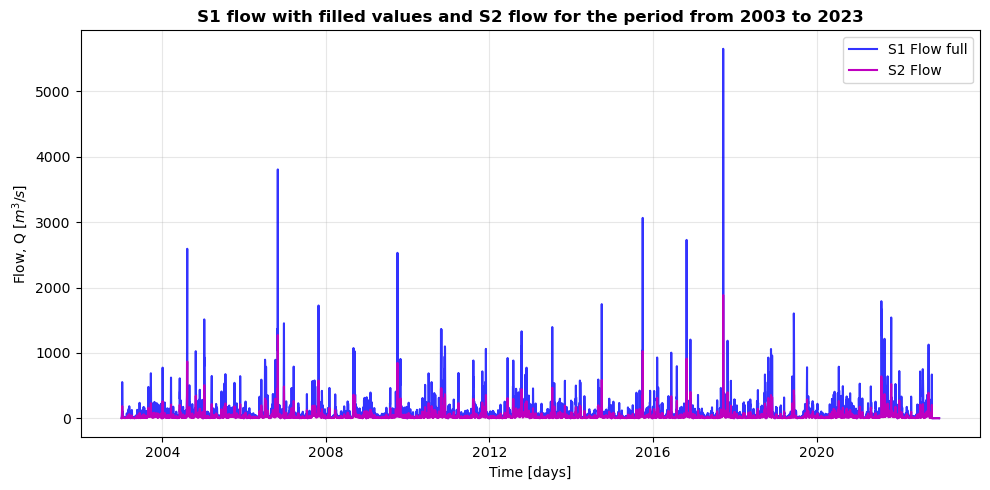

In [146]:
# Extend the S1 flow series to the beginning of the S2 series, from 2003 to 2023
# Copy the filled S1 into a new column
df_flows['flow_S1_2003_2023'] = df_flows['flow_S1_filled']

# Make a mask for the period before 2016 that needs to be extended
mask_pre = df_flows.index < "2016-12-28"  

# Predict only on those early dates, and use the already fitted model
X_pre = df_flows['flow_S2'].loc[mask_pre].values.reshape(-1,1)
pred_pre = model.predict(poly.transform(X_pre))

# Insert those extension predictions
df_flows['flow_S1_2003_2023'].loc[mask_pre] = pred_pre
print(f"length flow_S1_2003_2023:\t{len(df_flows['flow_S1_2003_2023'])}\nlength flow_S2:\t\t\t{len(df_flows['flow_S2'])}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df_flows['flow_S1_2003_2023'], label='S1 Flow full', color='b', alpha=0.8)
plt.plot(df_flows['flow_S2'], label='S2 Flow', color='m')
plt.xlabel('Time [days]')
plt.ylabel('Flow, Q [$m^3/s$]')
plt.title('S1 flow with filled values and S2 flow for the period from 2003 to 2023', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/S1_full.png", dpi=300)
plt.show()

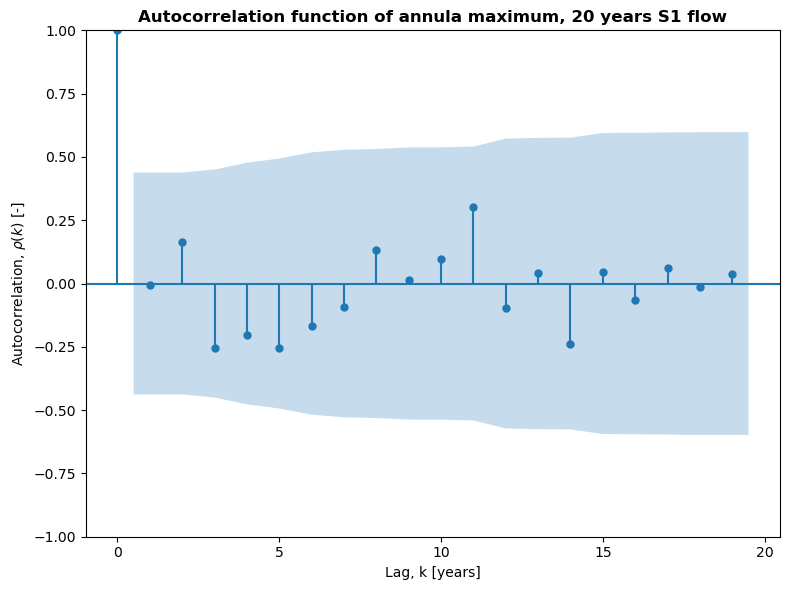

In [147]:
# Compute and plot the ACF (autocorrelation function) of the 20 years S1 series
s1_20y = df_flows['flow_S1_2003_2023']
annual_max = s1_20y.groupby(s1_20y.index.year).max()

# Plot the autocorrelation function up to 19 lags
fig, ax = plt.subplots(figsize=(8, 6))
plot_acf(annual_max, lags=19, ax=ax)
ax.locator_params(axis='x', integer=True)
ax.set_title("Autocorrelation function of annula maximum, 20 years S1 flow", fontweight='bold')
ax.set_xlabel("Lag, k [years]")
ax.set_ylabel(r"Autocorrelation, $\rho(k)$ [-]")
plt.tight_layout()
plt.savefig("figures/ACF_20y_S1.png", dpi=300)
plt.show()

In [148]:
# force df_flows back to exactly 2003–2022 window
# this is needed to avoid any issues with the index if the cell is run multiple times
# in this way the index is not cumulated
df_flows = df_flows.loc['2003-01-01':'2022-12-31'].copy()

# Extract daily values for each selected year
years_before = [2018, 2006, 2015, 2021, 2012]
years_after  = [2007, 2016, 2010, 2013, 2018]

s1_20y = df_flows['flow_S1_2003_2023'].copy()
s1_arr = 0
s1_arr = s1_20y.values
orig_start = s1_20y.index.min()  # Timestamp('2003-01-01')
orig_end   = s1_20y.index.max()  # Timestamp('2022-12-31')

pre_arrays  = [s1_arr[s1_20y.index.year == yr] for yr in years_before]
post_arrays = [s1_arr[s1_20y.index.year == yr] for yr in years_after]

print("len pre_arr:", len(pre_arrays))
print("len post_arr:", len(post_arrays))

arr_pre, arr_post = np.array([]), np.array([])
arr_pre  = np.concatenate(pre_arrays)
arr_post = np.concatenate(post_arrays)

print("arr_pre length:",  len(arr_pre))
print("arr_post length:", len(arr_post))

arr_30y = np.array([])
arr_30y = np.concatenate([arr_pre, s1_arr, arr_post])
# In the selected 30 years range [1998:2927] there are 7 leap years
# since there 7 leap years, the total number of days should be: 30 * 365 + 7 = 10957 days (check the print)
print(f"Total 30 years length: {len(arr_30y)} days")

# Create a new index for the 30-year period
# pre-period: ends the day before orig_start
idx_pre = pd.date_range(end=orig_start - pd.Timedelta(days=1), periods=len(arr_pre),  freq='D')
# orig-period:
idx_orig = s1_20y.index
# post-period: starts the day after orig_end
idx_post = pd.date_range(start=orig_end + pd.Timedelta(days=1), periods=len(arr_post), freq='D')

idx_30y = idx_pre.append(idx_orig).append(idx_post)

print(f"index pre-period: {idx_pre.min()} to {idx_pre.max()}")
print(f"index orig-period: {idx_orig.min()} to {idx_orig.max()}")
print(f"index post-period: {idx_post.min()} to {idx_post.max()}")
print(f"index 30-year period: {idx_30y.min()} to {idx_30y.max()}")

s1_30y = pd.Series(arr_30y, index=idx_30y, name='flow_S1_1998_2027')

# expand and assign
df_flows = df_flows.reindex(idx_30y)
df_flows['flow_S1_1998_2027'] = s1_30y

print(f"30-year span: {df_flows['flow_S1_1998_2027'].index.min()} to {df_flows['flow_S1_1998_2027'].index.max()}")

len pre_arr: 5
len post_arr: 5
arr_pre length: 1826
arr_post length: 1826
Total 30 years length: 10957 days
index pre-period: 1998-01-01 00:00:00 to 2002-12-31 00:00:00
index orig-period: 2003-01-01 00:00:00 to 2022-12-31 00:00:00
index post-period: 2023-01-01 00:00:00 to 2027-12-31 00:00:00
index 30-year period: 1998-01-01 00:00:00 to 2027-12-31 00:00:00
30-year span: 1998-01-01 00:00:00 to 2027-12-31 00:00:00


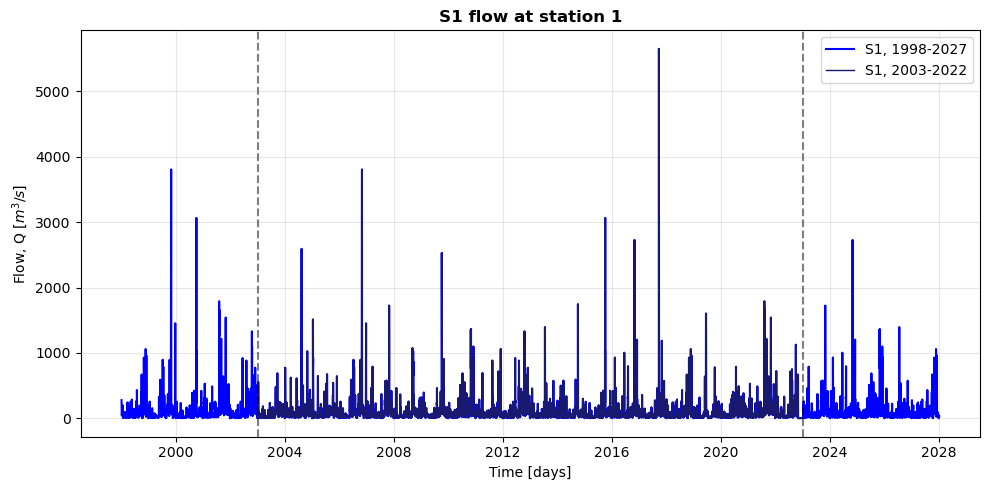

In [149]:
# Plot the original 20 years and the new 30 years S1 flow series
plt.figure(figsize=(10, 5))
plt.plot(s1_30y.index, s1_30y, label='S1, 1998-2027', color='b')
plt.plot(s1_20y.index, s1_20y, label='S1, 2003-2022', linewidth=1, color='midnightblue')
plt.axvline(s1_20y.index.min(), color='k', linestyle='--', alpha=0.5)
plt.axvline(s1_20y.index.max(), color='k', linestyle='--', alpha=0.5)
plt.xlabel('Time [days]')
plt.ylabel('Flow, Q [$m^3/s$]')
plt.title("S1 flow at station 1", fontweight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/S1_1998_2027.png", dpi=300)
plt.show()

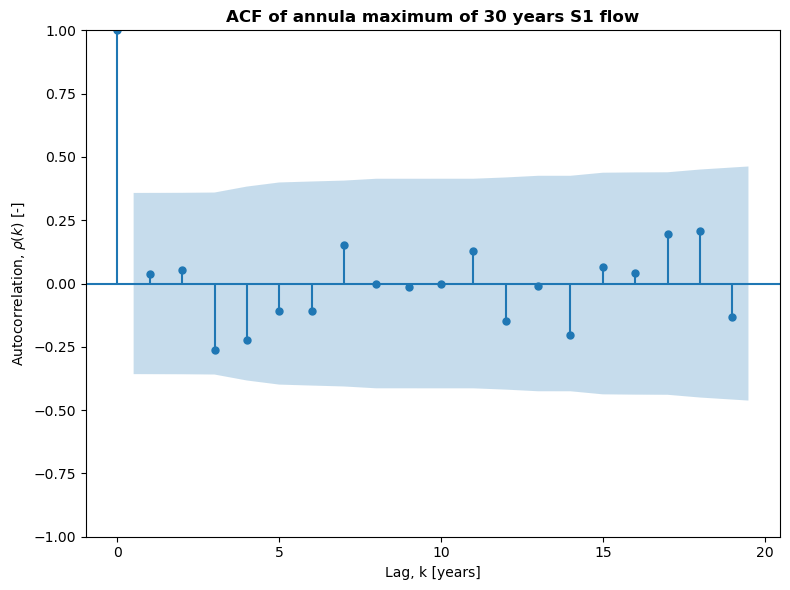

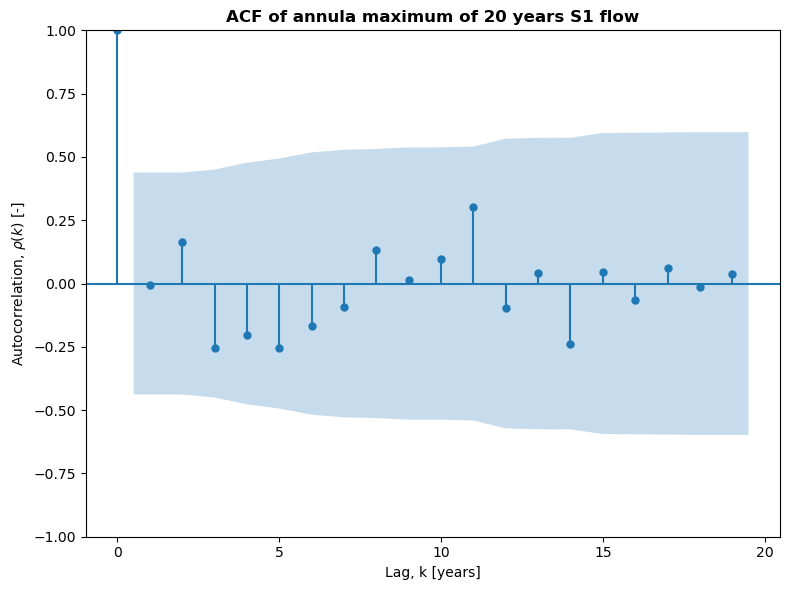

In [150]:
# Recompute and plot the ACF (autocorrelation function) of the 30 years S1 series
# Compute and plot the ACF of the 30 and 20 years S1 series
s1_30y = df_flows['flow_S1_1998_2027']
annual_max_30 = s1_30y.groupby(s1_30y.index.year).max()

# Compute and plot the ACF of the 20 years S1 series
s1_20y = df_flows['flow_S1_2003_2023']['2003-01-01':'2022-12-31']
annual_max_20 = s1_20y.groupby(s1_20y.index.year).max()

fig, ax = plt.subplots(figsize=(8, 6))
plot_acf(annual_max_30.values, lags=19, ax=ax)
ax.locator_params(axis='x', integer=True)
ax.set_title("ACF of annula maximum of 30 years S1 flow", fontweight='bold')
ax.set_xlabel("Lag, k [years]")
ax.set_ylabel(r"Autocorrelation, $\rho(k)$ [-]")
plt.tight_layout()
plt.savefig("figures/ACF_30y_S1.png", dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
plot_acf(annual_max_20, lags=19, ax=ax)
ax.locator_params(axis='x', integer=True)
ax.set_title("ACF of annula maximum of 20 years S1 flow", fontweight='bold')
ax.set_xlabel("Lag, k [years]")
ax.set_ylabel(r"Autocorrelation, $\rho(k)$ [-]")
plt.tight_layout()
plt.savefig("figures/ACF_20y_S1.png", dpi=300)
plt.show()

In [117]:
# BEN
'''# Build S1 over 20 years

s1_20y = s2.copy()

s1_20y[:-len(s1)] = model(s2[:-len(s1)])
s1_20y[-len(s1):] = s1[:]


#plt.figure(figsize=(6, 3), dpi=300) 
plt.plot(s1_20y)
plt.plot(s2)
plt.show()

# Annual Max serie
y = 20 
max_s1 = [np.nanmax(s1_20y[i*365:(i+1)*365]) for i in range(y)]
max_s1 = np.array(max_s1)

# Autocorelated serie
plot_acf(max_s1, lags= 19, alpha= None)
plt.show()

#Years selection
mean_max = np.mean(max_s1)
std_max = np.std(max_s1)
z = (max_s1 - mean_max) / std_max

#plt.figure(figsize=(6, 3), dpi=300) 
plt.plot(range(1, y+1), z, marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Autocorrelated Serie")
plt.xlabel("Year")
plt.ylabel("Standardized Max Flow")
plt.show()


#%% Swapping Coding

#Selecting which years -> kind of random, just trying to mix by following trend
#such as fluctuating above and below the mean and mixing the intensity 

swap_y_after = [2,14,4,11,16,19]

swap_y_before = [12,7,15,5,8]

before = []

after = []

for i in range(5):

    if i ==4: #Bissextile years 
        swap = s1_20y[swap_y_before[i] * 365 : (swap_y_before[i] + 1) * 365+1]     
        before = np.concatenate((before, swap)) 

        swap = s1_20y[swap_y_after[i] * 365 : (swap_y_after[i] + 1) * 365+1]     
        after = np.concatenate((after, swap)) 


    else:
        swap = s1_20y[swap_y_before[i] * 365 : (swap_y_before[i] + 1) * 365]     
        before = np.concatenate((before, swap)) 

        swap = s1_20y[swap_y_after[i] * 365 : (swap_y_after[i] + 1) * 365]     
        after = np.concatenate((after, swap)) 



s1_30y = before
s1_30y = np.concatenate((s1_30y, s1_20y.copy())) 
s1_30y = np.concatenate((s1_30y, after)) 


# Plot the new 30-year time series
#plt.figure(figsize=(10, 4), dpi=300)
plt.plot(s1_30y, label='30-year series')
plt.xlabel('Days')
plt.ylabel('Flow')
plt.title('Flow 1 30 years swapping method')
plt.grid(True)
plt.legend()
plt.show()'''

'# Build S1 over 20 years\n\ns1_20y = s2.copy()\n\ns1_20y[:-len(s1)] = model(s2[:-len(s1)])\ns1_20y[-len(s1):] = s1[:]\n\n\n#plt.figure(figsize=(6, 3), dpi=300) \nplt.plot(s1_20y)\nplt.plot(s2)\nplt.show()\n\n# Annual Max serie\ny = 20 \nmax_s1 = [np.nanmax(s1_20y[i*365:(i+1)*365]) for i in range(y)]\nmax_s1 = np.array(max_s1)\n\n# Autocorelated serie\nplot_acf(max_s1, lags= 19, alpha= None)\nplt.show()\n\n#Years selection\nmean_max = np.mean(max_s1)\nstd_max = np.std(max_s1)\nz = (max_s1 - mean_max) / std_max\n\n#plt.figure(figsize=(6, 3), dpi=300) \nplt.plot(range(1, y+1), z, marker=\'o\')\nplt.axhline(0, color=\'gray\', linestyle=\'--\')\nplt.title("Autocorrelated Serie")\nplt.xlabel("Year")\nplt.ylabel("Standardized Max Flow")\nplt.show()\n\n\n#%% Swapping Coding\n\n#Selecting which years -> kind of random, just trying to mix by following trend\n#such as fluctuating above and below the mean and mixing the intensity \n\nswap_y_after = [2,14,4,11,16,19]\n\nswap_y_before = [12,7,15,5,

In [118]:
# BEN
'''#Creating a dataframe which make the rest easier

# dates vector 5 years before and 5 after
dates = pd.date_range(start="1998-01-01", end="2027-12-31", freq="D")

# create datafram
df = pd.DataFrame({
    "date": dates,
    "flow": s1_30y
})

# Extract day, month, and year
df["day"] = df["date"].dt.day
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year'''


'#Creating a dataframe which make the rest easier\n\n# dates vector 5 years before and 5 after\ndates = pd.date_range(start="1998-01-01", end="2027-12-31", freq="D")\n\n# create datafram\ndf = pd.DataFrame({\n    "date": dates,\n    "flow": s1_30y\n})\n\n# Extract day, month, and year\ndf["day"] = df["date"].dt.day\ndf["month"] = df["date"].dt.month\ndf["year"] = df["date"].dt.year'

### Point c
Build the flow duration curve of the 30 years dataset for reconstructed station one data and calculate the reference minimal flow for instream flow protection based on the Q 347 approach

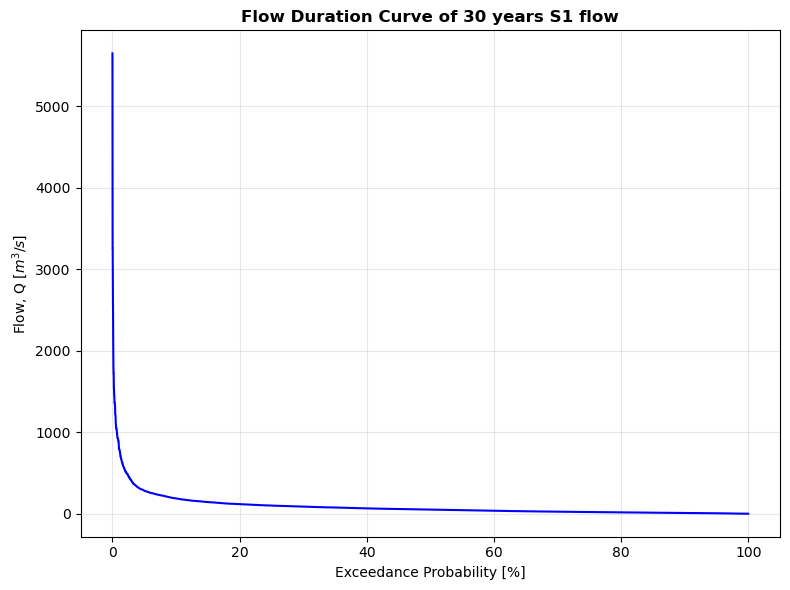

Reference minimal flow Q_347: 4.778 m^3/s

Check 1: Empirical exceedance:
 0.9507 --> 347.0 days/year

Check 2: Closest rank method:
 Q = 4.772 m^3/s (at exceedance P = 0.9507 --> 347.0 days/year)


In [151]:
# Weibull sorting
s1_30_years = df_flows['flow_S1_1998_2027'].values
# Sort flows in descending order
sortedQ = np.sort(s1_30_years)[::-1]
n = len(sortedQ)

# Exceedance probability: rank / (N + 1)
ranks = np.arange(1, n+1)
exceed_prob = ranks / (n + 1)

plt.figure(figsize=(8, 6))
plt.plot(exceed_prob * 100, sortedQ, color='b')
plt.xlabel('Exceedance Probability [%]')
plt.ylabel('Flow, Q [$m^3/s$]')
plt.title('Flow Duration Curve of 30 years S1 flow', fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/flow_duration_curve_30y_S1.png", dpi=300)
plt.show()


# Compute Q_347 via percentile (linear interpolation)
# Fraction of days to exceed (~0.95068)
P_target = 347 / 365 
# Percentile of lowest flows (~4.932%)                
q_pct = (1 - P_target) * 100      

# Compute the 347th day minimal flow
Q347 = np.percentile(s1_30_years, q_pct, interpolation='linear')
print(f"Reference minimal flow Q_347: {Q347:.3f} m^3/s\n")

# Check: empirical exceedance probability of Q347
emp_P = np.sum(s1_30_years >= Q347) / n
emp_days = emp_P * 365
print(f"Check 1: Empirical exceedance:\n {emp_P:.4f} --> {emp_days:.1f} days/year\n")

# Check: nearest‐rank Weibull match
idx_closest = np.argmin(np.abs(exceed_prob - P_target))
Q347_by_idx = sortedQ[idx_closest]
P_by_idx   = exceed_prob[idx_closest]
days_by_idx = P_by_idx * 365
print(f"Check 2: Closest rank method:")
print(f" Q = {Q347_by_idx:.3f} m^3/s (at exceedance P = {P_by_idx:.4f} --> {days_by_idx:.1f} days/year)")

### Point d
Obtain the daily mean annual behaviour from data

Mean flows for the first 10 days of year:
1      72.000914
2      57.183378
3      72.782530
4      73.451693
5      57.975255
6      72.907306
7      80.608452
8      77.146803
9     182.241865
10    123.483409


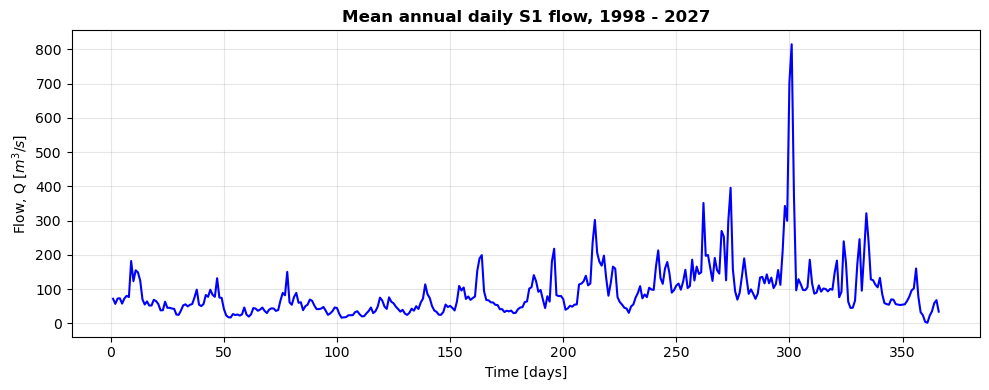

In [153]:
s1_30_years = df_flows['flow_S1_1998_2027']

# Drop Feb 29 so each day‐of‐year has the same number of samples
mask = ~((s1_30_years.index.month == 2) & (s1_30_years.index.day == 29))
s1_no_leap = s1_30_years[mask]

# Group by day-of-year and compute the mean flow for each calendar day
daily_mean_annual = s1_no_leap.groupby(s1_no_leap.index.dayofyear).mean()

# Print
print("Mean flows for the first 10 days of year:")
print(daily_mean_annual.head(10).to_string())

# Plot
plt.figure(figsize=(10, 4))
plt.plot(daily_mean_annual.index, daily_mean_annual.values, color='b')
plt.xlabel('Time [days]')
plt.ylabel('Flow, Q [$m^3/s$]')
plt.title('Mean annual daily S1 flow, 1998 - 2027', fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/mean_annual_daily_S1.png", dpi=300)
plt.show()

In [154]:
#daily_mean_annual = df.groupby('year')['flow'].mean().to_list()
#print(daily_mean_annual)

### Point e
Build the monthly mean annual time series, which will be used for the financial analysis

Mean flows [m^3/s]:
1      70.673356
2      56.609051
3      54.303562
4      35.125547
5      49.332240
6      72.230629
7      92.590979
8     117.992387
9     164.713862
10    188.607720
11    128.859163
12     72.057283
Name: flow_S1_1998_2027, dtype: float64


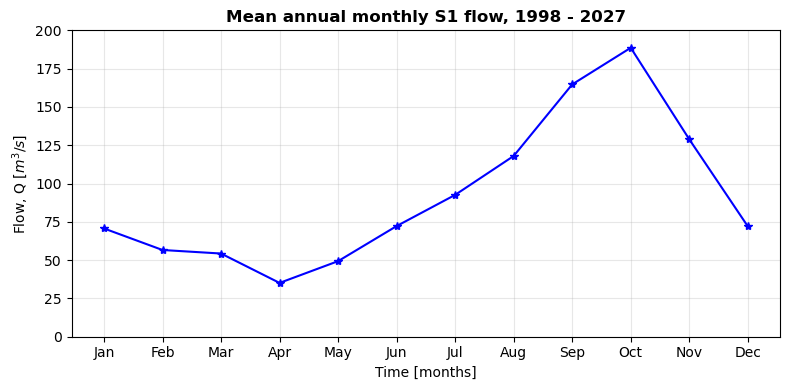

In [155]:
# Compute the monthly mean time series
s1_30_years = df_flows['flow_S1_1998_2027']

# Drop Feb 29 so each day‐of‐year has the same number of samples
mask = ~((s1_30_years.index.month == 2) & (s1_30_years.index.day == 29))
s1_no_leap = s1_30_years[mask]

# Group by month-of-year and compute the mean flow for each calendar month
monthly_mean_annual = s1_no_leap.groupby(s1_no_leap.index.month).mean()

# Print
print(f"Mean flows [m^3/s]:\n{monthly_mean_annual}")

# Plot 
plt.figure(figsize=(8, 4))
plt.plot(monthly_mean_annual.index, monthly_mean_annual.values, marker='*', color='b')
plt.xlabel('Time [months]')
plt.ylabel('Flow, Q [$m^3/s$]')
plt.ylim(0, 200)
months = range(1, 13)
labels = [calendar.month_abbr[m] for m in range(1,13)]
plt.xticks(months, labels, rotation=0)
plt.title('Mean annual monthly S1 flow, 1998 - 2027', fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/mean_annual_monthly_S1.png", dpi=300)
plt.show()

In [156]:
#monthly_mean_overall = df.groupby('month')['flow'].mean().to_list()
#print(monthly_mean_overall)

### Point f
Use the reconstructed data for S1 to build two new series as the sequence of wet periods and the sequence of dry periods. To the purpose, use the annual mean as discriminant value for the wet years (above the mean, Aug Dec) and viceversa. We will use these series later to build the Pareto frontier of the system

Aug-Dec threshold = 134.285 m^3/s

Wet-spell lengths (years):
1
2
1
2
1
1
1
1
1
1
Dry-spell lengths (years):
1
1
1
1
2
1
4
3
1
1
2


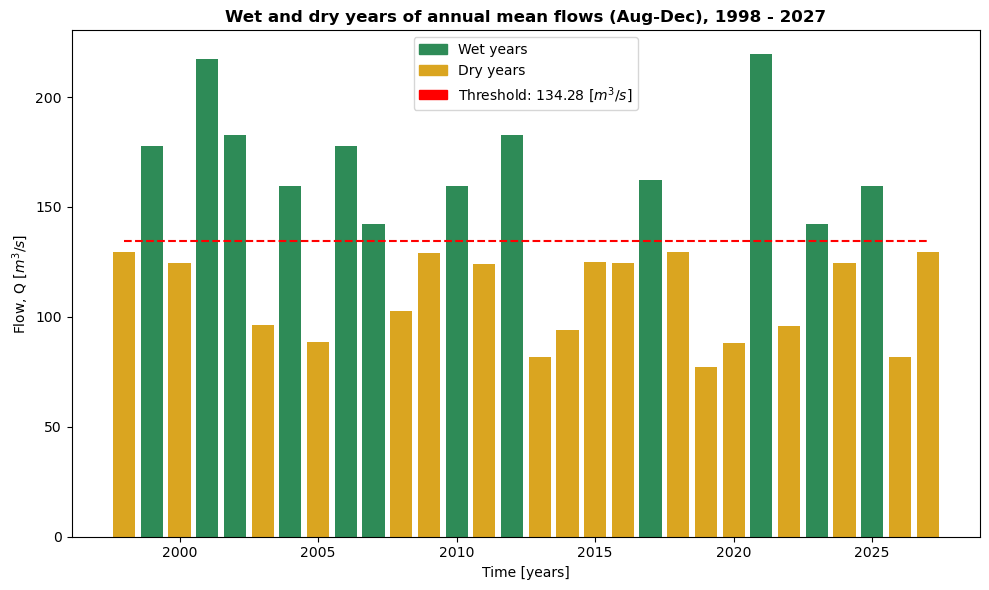

In [157]:
# Compute the annual mean flow (threshold) and identify wet and dry years
s1 = df_flows['flow_S1_1998_2027']

# Subset to August–December and compute one mean per year
mask_aug_dec = s1.index.month.isin([8,9,10,11,12])
s1_augdec = s1[mask_aug_dec]
annual_augdec_mean = s1_augdec.groupby(s1_augdec.index.year).mean()
annual_augdec_mean.index.name = 'year'

# Threshold: long-term mean of those Aug–Dec means
threshold = annual_augdec_mean.mean()

# Classify wet vs dry years
is_wet = annual_augdec_mean > threshold

# Build run-length sequences
runs = []
current_len = 0
current_state = is_wet.iloc[0]

for wet in is_wet:
    if wet == current_state:
        current_len += 1
    else:
        runs.append((current_state, current_len))
        current_state = wet
        current_len = 1
runs.append((current_state, current_len))

# Split into two Series
wet_periods = pd.Series([length for state, length in runs if state],
                        name='wet_period_years')
dry_periods = pd.Series([length for state, length in runs if not state],
                        name='dry_period_years')

# Print results
print(f"Aug-Dec threshold = {threshold:.3f} m^3/s\n")
print(f"Wet-spell lengths (years):\n{wet_periods.to_string(index=False)}")
print(f"Dry-spell lengths (years):\n{dry_periods.to_string(index=False)}")

# Plot
plt.figure(figsize=(10,6))
plt.bar(annual_augdec_mean.index, annual_augdec_mean.values, color=['seagreen' if w else 'goldenrod' for w in is_wet])
plt.hlines(threshold, annual_augdec_mean.index.min(), annual_augdec_mean.index.max(), colors='red', linestyles='--', label=f'Threshold: {threshold:.2f}')
plt.xlabel('Time [years]')
plt.ylabel('Flow, Q [$m^3/s$]')
plt.title('Wet and dry years of annual mean flows (Aug-Dec), 1998 - 2027', fontweight='bold')
legend_handles = [
    Patch(color='seagreen', label='Wet years'),
    Patch(color='goldenrod', label='Dry years'),
    Patch(color='red', linestyle='-', label=f'Threshold: {threshold:.2f} $[m^3/s]$')]
plt.legend(handles=legend_handles, loc='best')
plt.tight_layout()
plt.savefig("figures/wet_dry_years_S1.png", dpi=300)
plt.show()

In [158]:
'''#Visualise the data for a year

plt.scatter(np.arange(1,13,1),monthly_mean_overall)
plt.hlines(np.mean(s1_30y),0,12)
plt.show()

#So  [December-juillet] = dry ///  [Aug-Nov] = Wet

df["period"] = np.where(df["month"].between(8, 11), "wet", "dry") #Assign new column in df Wet/Dry based on Aug-Now (8-11) is defined as wet

# Step 5: Extract wet and dry series
wet = df[df["period"] == "wet"]["flow"].to_list()
dry = df[df["period"] == "dry"]["flow"].to_list()'''

'#Visualise the data for a year\n\nplt.scatter(np.arange(1,13,1),monthly_mean_overall)\nplt.hlines(np.mean(s1_30y),0,12)\nplt.show()\n\n#So  [December-juillet] = dry ///  [Aug-Nov] = Wet\n\ndf["period"] = np.where(df["month"].between(8, 11), "wet", "dry") #Assign new column in df Wet/Dry based on Aug-Now (8-11) is defined as wet\n\n# Step 5: Extract wet and dry series\nwet = df[df["period"] == "wet"]["flow"].to_list()\ndry = df[df["period"] == "dry"]["flow"].to_list()'

## Part 2

In [159]:
#Available Data

# Months
month = ["jan", "feb", "march", "april","may","june","july","Aug","sept","oct","nov","dec"]

# Mean monthly temperatures [°C]
temp_month = [24.72, 24.88, 25.71, 26.68, 27.02, 26.47, 25.94, 25.92, 25.9, 25.83, 25.65, 25.21] 

# Water requirement to T ratio [mm/(°C*day)]
w_req_day = [3.81, 5.04, 4.62, 6.85, 6.17, 6.59, 6.78, 8.36, 6.96, 4.82, 4.50, 7.03]

# Crop coefficients [-]
kc = [0.7, 1.1, 1.1, 0.5, 0.7 , 1.1, 1.1, 0.5, 0.7, 1.1, 1.1, 0.5]

# Mean cumulated monthly rainfall [mm/month]
mean_cumul_rain = [137, 96, 93, 97, 189, 248, 291, 310, 281, 280, 230, 207]

# Total irrigated surface [ha]
S = 370

# Number of days in a month
number_day_month = 30 

### Point a
Use the provided monthly mean temperature and related ratio to the reference evapotranspiration ET0 to obtain ET0

ET0 [mm/day]:	 ['94.18', '125.40', '118.78', '182.76', '166.71', '174.44', '175.87', '216.69', '180.26', '124.50', '115.42', '177.23']
ETcrop [mm/day]: ['65.93', '137.93', '130.66', '91.38', '116.70', '191.88', '193.46', '108.35', '126.18', '136.95', '126.97', '88.61']


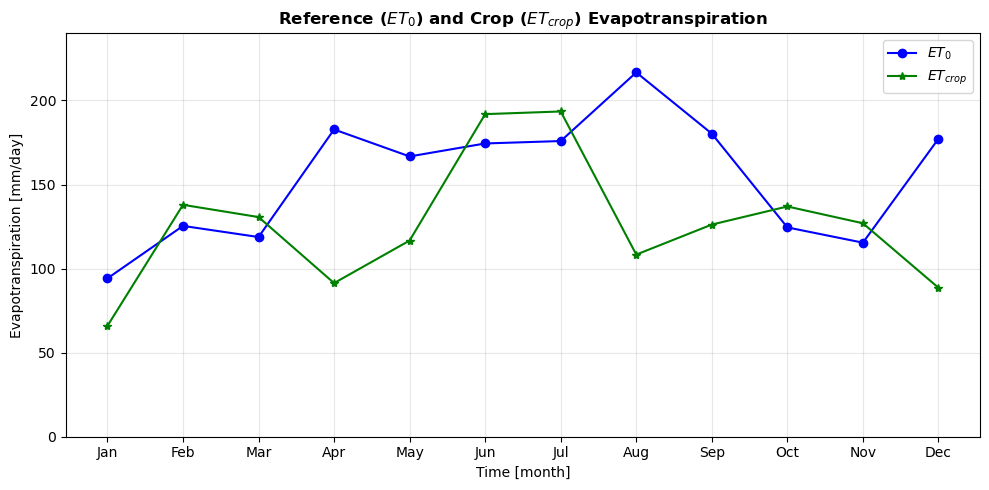

In [160]:
# Monthly names
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

# Compute reference evapotranspiration: ET0 = w_req_day * temp_month [mm/day]
ET0 = [w_req_day[i] * temp_month[i] for i in range(12)]

# Compute crop evapotranspiration: ETcrop = ET0 * kc [mm/day]
ETcrop = [ET0[i] * kc[i] for i in range(12)]

# Print ET0 and ETcrop values
print("ET0 [mm/day]:\t", ["{:.2f}".format(val) for val in ET0])
print("ETcrop [mm/day]:", ["{:.2f}".format(val) for val in ETcrop])

# Plot ET0 and ETcrop
plt.figure(figsize=(10, 5))
plt.plot(months, ET0, marker='o', label='$ET_0$', color='blue')
plt.plot(months, ETcrop, marker='*', label='$ET_{crop}$', color='green')
plt.xlabel('Time [month]')
plt.ylabel('Evapotranspiration [mm/day]')
plt.ylim(0, 240)
plt.title('Reference ($ET_0$) and Crop ($ET_{crop}$) Evapotranspiration', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/ET0_ETcrop.png", dpi=300)
plt.show()

### Point b
Calculate the irrigation net water need using the mass balance equation and assuming that the reserve is zero each month and that effective precipitation is equal to falling rain amount (no interception nor losses)

Monthly irrigation need [mm/month]:
['1840.8', '4042.0', '3826.7', '2644.4', '3312.0', '5508.4', '5512.8', '2940.4', '3504.5', '3828.5', '3579.0', '2451.4']
Monthly net water need [m^3/month]:
['6,811,135', '14,955,554', '14,158,962', '9,784,169', '12,254,331', '20,381,194', '20,397,418', '10,879,362', '12,966,813', '14,165,523', '13,242,392', '9,070,160']


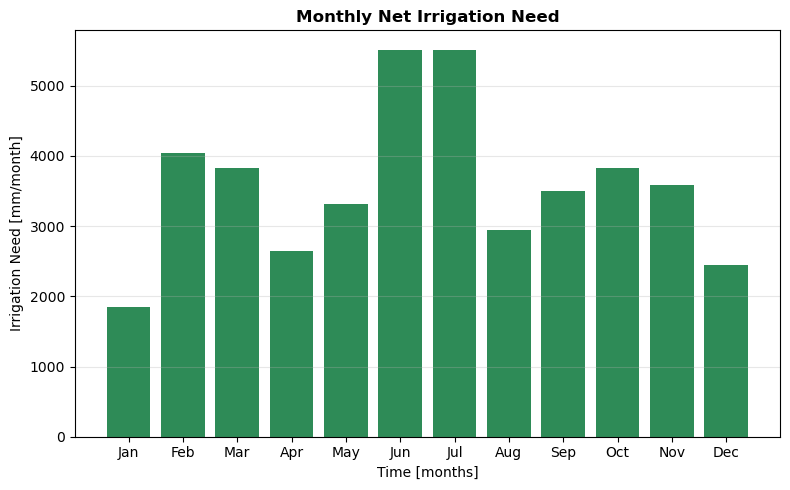

In [161]:
# Assume no interception nor loss and stock is 0 at begining each month

# Monthly names
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

# Net irrigation need [mm/month]
irrigation_mm = []
for i in range(12):
    need = ETcrop[i] * number_day_month - mean_cumul_rain[i]
    irrigation_mm.append(max(0, need))

# Convert to volume [m^3/month]: mm --> m by /1000, ha --> m2 by *10000
net_water_need = [irrigation_mm[i] * (S * 1e4) / 1000 for i in range(12)]

# Print results
print("Monthly irrigation need [mm/month]:")
print([f"{val:.1f}" for val in irrigation_mm])

print("Monthly net water need [m^3/month]:")
print([f"{val:,.0f}" for val in net_water_need])

# Plot
plt.figure(figsize=(8,5))
plt.bar(months, irrigation_mm, color='seagreen')
plt.xlabel('Time [months]')
plt.ylabel('Irrigation Need [mm/month]')
plt.title('Monthly Net Irrigation Need', fontweight='bold')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig("figures/net_irrigation_need.png", dpi=300)
plt.show()

### Point c
Use the irrigation efficiency for gravity irrigation in a sandy soil to obtain the gross water need

Gross water volume need [m^3/month]:
['19,460,385', '42,730,154', '40,454,178', '27,954,769', '35,012,375', '58,231,984', '58,278,336', '31,083,890', '37,048,037', '40,472,924', '37,835,407', '25,914,742']


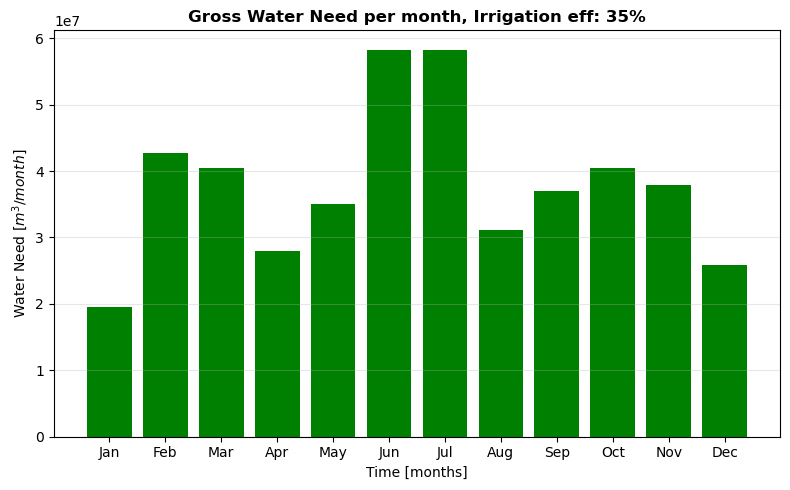

In [162]:
# Monthly names
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

# Irrigation efficiency for sandy-soil gravity systems: 0.3 - 0.43
eff_grav_irr = 0.35 

# Compute gross water need [m^3/month]
gross_water_need = [val / eff_grav_irr for val in net_water_need]

# Print results
print("Gross water volume need [m^3/month]:")
print([f"{val:,.0f}" for val in gross_water_need])

# Plot
plt.figure(figsize=(8,5))
plt.bar(months, gross_water_need, color='green')
plt.xlabel('Time [months]')
plt.ylabel('Water Need [$m^3/month$]')
plt.title('Gross Water Need per month, Irrigation eff: 35%', fontweight='bold')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig("figures/gross_water_need.png", dpi=300)
plt.show()

### Point d
Calculate the continous fictitious flowrate to irrigate the total assigned surface S; express the fictitious continuoum flowrate in m3/s; this is the flow that is constantly provided each day of the month

Fictitious continuous flow [m^3/s] for each month:
jan: 7.51
feb: 16.49
march: 15.61
april: 10.79
may: 13.51
june: 22.47
july: 22.48
Aug: 11.99
sept: 14.29
oct: 15.61
nov: 14.6
dec: 10.0


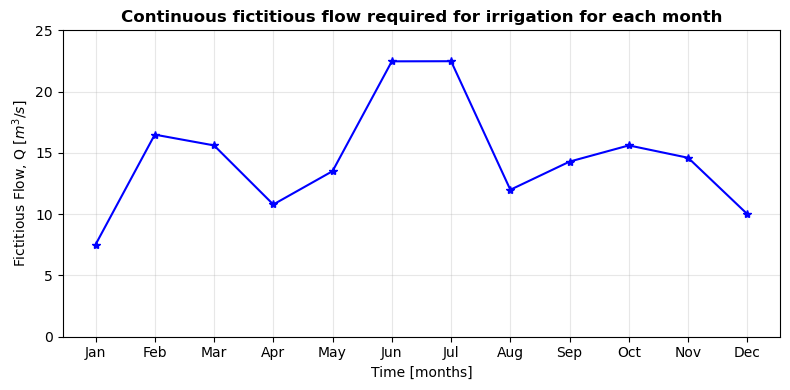

In [163]:
# Monthly names
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

# Compute seconds per month (assume 30-day months)
seconds_per_month = 30 * 24 * 3600

# Compute continuous flow for each month [m^3/s] (entire surface S)
fict_flow = [round(volume / seconds_per_month, 2) for volume in gross_water_need]

# Print
print("Fictitious continuous flow [m^3/s] for each month:")
for m, f in zip(month, fict_flow): print(f"{m}: {f}")

# Plot
plt.figure(figsize=(8,4))
plt.plot(months, fict_flow, marker='*', color='blue')
plt.xlabel('Time [months]')
plt.ylabel('Fictitious Flow, Q [$m^3/s$]')
plt.ylim(0, 25)
plt.title('Continuous fictitious flow required for irrigation for each month', fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/fictitious_flow.png", dpi=300)
plt.show()

### Point e
Seek for a proportional relationship between the monthly mean river discharges that you calculated in Project Week 1 and the continous fictitious flowrate for irrigation needs. These proportions will be used later for successive project phases

Monthly Mean River Discharge [m^3/s]:
 [ 70.67335598  56.60905092  54.30356196  35.12554714  49.33223965
  72.23062935  92.59097932 117.99238676 164.71386234 188.60771969
 128.85916312  72.05728251]

Fictitious Irrigation Flow [m^3/s]:
 [7.51, 16.49, 15.61, 10.79, 13.51, 22.47, 22.48, 11.99, 14.29, 15.61, 14.6, 10.0]


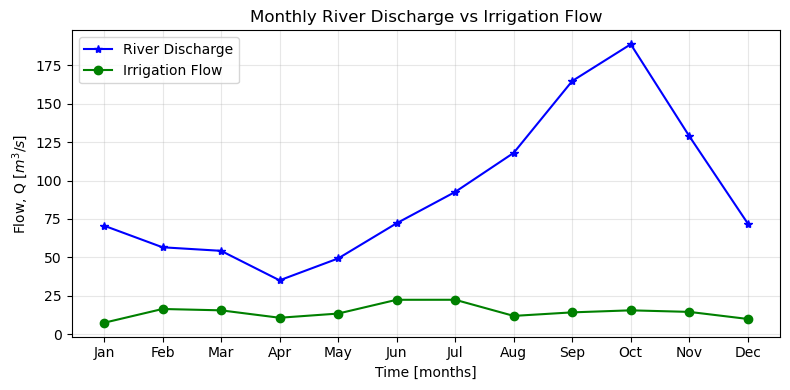

Monthly Discharge / Irrigation Flow Ratio:
 [9.41056670791706, 3.432932135629368, 3.4787675820122423, 3.2553797163822407, 3.651535133549421, 3.214536241634341, 4.118815805880605, 9.840899646498869, 11.526512410100556, 12.082493253496136, 8.825970076813174, 7.205728251345238]


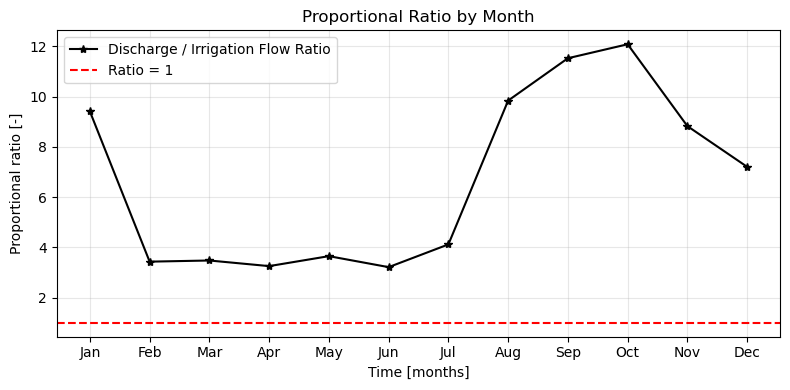

In [164]:
# Monthly names
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

# Print both series for inspection
print("Monthly Mean River Discharge [m^3/s]:\n", monthly_mean_annual.values)
print("\nFictitious Irrigation Flow [m^3/s]:\n", fict_flow)

# Plot both time series
plt.figure(figsize=(8,4))
plt.plot(months, monthly_mean_annual.values, marker='*', label='River Discharge', color='blue')
plt.plot(months, fict_flow, marker='o', label='Irrigation Flow', color='green')
plt.xlabel('Time [months]')
plt.ylabel('Flow, Q [$m^3/s$]')
plt.title('Monthly River Discharge vs Irrigation Flow')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/monthly_discharge_vs_irrigation_flow.png", dpi=300)
plt.show()

# Compute proportional ratio: river discharge / irrigation flow [m^3/s]
ratio = [(monthly_mean_annual.values[i] / fict_flow[i]) for i in range(12)]

# Print ratio
print("Monthly Discharge / Irrigation Flow Ratio:\n", ratio)

# Plot the ratio, if ratio < 1 then irrigation flow is larger than river discharge
plt.figure(figsize=(8,4))
plt.plot(months, ratio, marker='*', color='k', label='Discharge / Irrigation Flow Ratio')
plt.axhline(1, color='red', linestyle='--', label='Ratio = 1')
plt.xlabel('Time [months]')
plt.ylabel('Proportional ratio [-]')
plt.title('Proportional Ratio by Month')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("figures/monthly_discharge_irr_ratio.png", dpi=300)
plt.show()